<a href="https://colab.research.google.com/github/moaamer2/color_unblind/blob/main/Models/Tritanopia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io, os

# إعداد مجلد الإخراج
output_dir = "/content/drive/MyDrive/downloaded_images_T"
os.makedirs(output_dir, exist_ok=True)

# ID الفولدر (اللي فيه الصور)
folder_id = "1dcdU7wc3-7zXYpbaq_UYR6XJR29ZW3hr"

# إنشاء خدمة Google Drive
service = build('drive', 'v3')

# تحميل كل الملفات مع التصفح عبر الصفحات (pagination)
page_token = None
all_files = []

while True:
    response = service.files().list(
        q=f"'{folder_id}' in parents and mimeType contains 'image/' and trashed=false",
        fields="nextPageToken, files(id, name)",
        pageSize=1000,  # عدد الملفات في كل صفحة
        pageToken=page_token
    ).execute()

    all_files.extend(response.get('files', []))
    page_token = response.get('nextPageToken', None)

    if page_token is None:
        break  # خلاص مفيش صفحات تانية

print(f"📸 سيتم تحميل {len(all_files)} صورة من Google Drive...")

# تحميل الصور واحدة واحدة
for i, file in enumerate(all_files):
    file_id = file['id']
    file_name = file['name']
    file_path = os.path.join(output_dir, file_name)

    # تحميل الصورة
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(file_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()

    if (i + 1) % 50 == 0:
        print(f"✅ تم تحميل {i+1} صورة...")

print(f"🎉 تم تحميل {len(all_files)} صورة بنجاح!")


📸 سيتم تحميل 8186 صورة من Google Drive...
✅ تم تحميل 50 صورة...
✅ تم تحميل 100 صورة...
✅ تم تحميل 150 صورة...
✅ تم تحميل 200 صورة...
✅ تم تحميل 250 صورة...
✅ تم تحميل 300 صورة...
✅ تم تحميل 350 صورة...
✅ تم تحميل 400 صورة...
✅ تم تحميل 450 صورة...
✅ تم تحميل 500 صورة...
✅ تم تحميل 550 صورة...
✅ تم تحميل 600 صورة...
✅ تم تحميل 650 صورة...
✅ تم تحميل 700 صورة...
✅ تم تحميل 750 صورة...
✅ تم تحميل 800 صورة...
✅ تم تحميل 850 صورة...
✅ تم تحميل 900 صورة...
✅ تم تحميل 950 صورة...
✅ تم تحميل 1000 صورة...
✅ تم تحميل 1050 صورة...
✅ تم تحميل 1100 صورة...
✅ تم تحميل 1150 صورة...
✅ تم تحميل 1200 صورة...
✅ تم تحميل 1250 صورة...
✅ تم تحميل 1300 صورة...
✅ تم تحميل 1350 صورة...
✅ تم تحميل 1400 صورة...
✅ تم تحميل 1450 صورة...
✅ تم تحميل 1500 صورة...
✅ تم تحميل 1550 صورة...
✅ تم تحميل 1600 صورة...
✅ تم تحميل 1650 صورة...
✅ تم تحميل 1700 صورة...
✅ تم تحميل 1750 صورة...
✅ تم تحميل 1800 صورة...
✅ تم تحميل 1850 صورة...
✅ تم تحميل 1900 صورة...
✅ تم تحميل 1950 صورة...
✅ تم تحميل 2000 صورة...
✅ تم تحميل 2050 صو

In [ ]:
# ======================================
# 📦 تثبيت المكتبات المطلوبة
# ======================================
!pip install --quiet daltonlens Pillow numpy

# ======================================
# 🧩 الاستيراد
# ======================================
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
from daltonlens import simulate

# ======================================
# 🗂️ إعداد المسارات
# ======================================
input_dir = "/content/drive/MyDrive/downloaded_images_T"   # الصور الأصلية الخاصة بالنوع الثالث
output_dir = "/content/drive/MyDrive/pix2pix_pairs_t"      # فولدر الإخراج
os.makedirs(output_dir, exist_ok=True)

# ======================================
# 🧠 نوع عمى الألوان المستخدم (النوع الثالث)
# ======================================
cvd_type = simulate.Deficiency.TRITAN  # 👈 Tritanopia بدل Deuteranopia
simulator = simulate.Simulator_Machado2009()

# ======================================
# 🎨 دالة التصحيح (Daltonization بسيطة)
# ======================================
def daltonize_simple(original, simulated):
    error = original.astype(int) - simulated.astype(int)
    corrected = original.astype(int) + error
    corrected = np.clip(corrected, 0, 255).astype("uint8")
    return corrected

# ======================================
# 🔁 المعالجة الكاملة — آمنة ومستمرة
# ======================================
count = 0
skipped = 0

for file_name in os.listdir(input_dir):
    if not file_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(input_dir, file_name)
    save_path = os.path.join(output_dir, file_name)

    # ✅ لو الصورة دي اتعملت قبل كده — تخطاها
    if os.path.exists(save_path):
        print(f"⏭️ تم تخطي {file_name} (موجودة بالفعل)")
        continue

    # ⚠️ محاولة فتح الصورة وتجنب الصور التالفة
    try:
        img = Image.open(img_path).convert("RGB").resize((256, 256))
    except UnidentifiedImageError:
        print(f"⚠️ الصورة {file_name} تالفة أو غير صالحة، تم تخطيها.")
        skipped += 1
        continue
    except Exception as e:
        print(f"⚠️ تخطيت {file_name} بسبب خطأ غير متوقع: {e}")
        skipped += 1
        continue

    img_np = np.asarray(img)

    # --- Simulation ---
    simulated = simulator.simulate_cvd(img_np, cvd_type, severity=1.0)
    sim_img = Image.fromarray(simulated.astype("uint8"))

    # --- Correction ---
    corrected = daltonize_simple(img_np, simulated)
    corr_img = Image.fromarray(corrected.astype("uint8"))

    # --- Combine pair (256x512) ---
    pair_img = Image.new("RGB", (512, 256))
    pair_img.paste(sim_img, (0, 0))
    pair_img.paste(corr_img, (256, 0))

    # --- Save output ---
    pair_img.save(save_path)
    count += 1

    if count % 50 == 0:
        print(f"✅ تمت معالجة {count} صورة...")

print(f"\n🎉 تم إنشاء {count} صور Pix2Pix بنجاح في المجلد: {output_dir}")
print(f"⚠️ تم تخطي {skipped} صورة تالفة أو مكررة.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.0 MB/s eta 0:00:00
✅ تمت معالجة 50 صورة...
✅ تمت معالجة 100 صورة...
✅ تمت معالجة 150 صورة...
✅ تمت معالجة 200 صورة...
✅ تمت معالجة 250 صورة...
✅ تمت معالجة 300 صورة...
✅ تمت معالجة 350 صورة...
✅ تمت معالجة 400 صورة...
✅ تمت معالجة 450 صورة...
✅ تمت معالجة 500 صورة...
✅ تمت معالجة 550 صورة...
✅ تمت معالجة 600 صورة...
✅ تمت معالجة 650 صورة...
✅ تمت معالجة 700 صورة...
✅ تمت معالجة 750 صورة...
✅ تمت معالجة 800 صورة...
✅ تمت معالجة 850 صورة...
✅ تمت معالجة 900 صورة...
✅ تمت معالجة 950 صورة...
✅ تمت معالجة 1000 صورة...
✅ تمت معالجة 1050 صورة...
✅ تمت معالجة 1100 صورة...
✅ تمت معالجة 1150 صورة...
✅ تمت معالجة 1200 صورة...
✅ تمت معالجة 1250 صورة...
✅ تمت معالجة 1300 صورة...
✅ تمت معالجة 1350 صورة...
✅ تمت معالجة 1400 صورة...
✅ تمت معالجة 1450 صورة...
✅ تمت معالجة 1500 صورة...
✅ تمت معالجة 1550 صورة...
✅ تمت معالجة 1600 صورة...
✅ تمت معالجة 1650 صورة...
✅ تمت معالجة 1700 صورة...
✅ تمت معالجة 1750 صورة...
✅ تمت معالجة 1800 صورة...
✅ تمت 

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# المسار للفولدر اللي فيه الصور المزدوجة
dataset_dir = "/content/drive/MyDrive/pix2pix_pairs_t"
train_dir = "/content/drive/MyDrive/pix2pix_dataset_t/train"
test_dir = "/content/drive/MyDrive/pix2pix_dataset_t/test"

# إنشاء الفولدرات لو مش موجودة
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# قراءة كل أسماء الصور
all_images = [f for f in os.listdir(dataset_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# تقسيم Train/Test بنسبة 80% - 20%
train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

# نسخ الملفات إلى الفولدرات الجديدة
for file in train_files:
    shutil.copy(os.path.join(dataset_dir, file), os.path.join(train_dir, file))

for file in test_files:
    shutil.copy(os.path.join(dataset_dir, file), os.path.join(test_dir, file))

print(f"✅ تم التقسيم بنجاح:")
print(f"- عدد صور التدريب: {len(train_files)}")
print(f"- عدد صور الاختبار: {len(test_files)}")


✅ تم التقسيم بنجاح:
- عدد صور التدريب: 6548
- عدد صور الاختبار: 1638


In [ ]:
# train_improved_pytorch_drive.py
# نسخة محسّنة من تدريب Pix2Pix بـ PyTorch مع حفظ تلقائي على Google Drive
# يشمل تحسينات على الأداء، Augmentations إضافية، وحفظ النتائج بشكل آمن

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import save_image
import shutil
from google.colab import drive

# ---------------- Google Drive Setup ----------------
drive.mount('/content/drive')
GDRIVE_DIR = "/content/drive/MyDrive/pix2pix_result_t"
os.makedirs(GDRIVE_DIR, exist_ok=True)

# ---------------- Configuration ----------------
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Paths
TRAIN_DIR = "/content/drive/MyDrive/pix2pix_dataset_t/train"
VAL_DIR = None  # ضع فولدر فاليديشن لو عندك
OUTPUT_DIR = "/content/drive/MyDrive/pix2pix_dataset_t/out"
os.makedirs(OUTPUT_DIR, exist_ok=True)
SAMPLES_DIR = os.path.join(OUTPUT_DIR, "Evaluation")
os.makedirs(SAMPLES_DIR, exist_ok=True)

CHECKPOINT_GEN = os.path.join(OUTPUT_DIR, "gen_best_t.pth.tar")
CHECKPOINT_DISC = os.path.join(OUTPUT_DIR, "disc_best_t.pth.tar")

# Hyperparams
BATCH_SIZE = 4
NUM_WORKERS = min(os.cpu_count(), 4)
IMAGE_SIZE = 256
CHANNELS_IMG = 3
LEARNING_RATE = 2e-4
L1_LAMBDA = 100
NUM_EPOCHS = 100
USE_MIXED_PRECISION = True
SAVE_EVERY = 5
THRESH_DIFF = 0.03

# ---------------- Dataset ----------------
class MapDataset(Dataset):
    def __init__(self, root_dir, image_size=IMAGE_SIZE, is_train=True):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.is_train = is_train
        self.image_size = image_size

        # Augmentations
        if self.is_train:
            self.both = A.Compose([
                A.Resize(286,286),
                A.RandomCrop(image_size,image_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.HueSaturationValue(p=0.3)
            ], additional_targets={"image0":"image"})
        else:
            self.both = A.Compose([A.Resize(image_size,image_size)], additional_targets={"image0":"image"})

        self.to_tensor = A.Compose([
            A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), max_pixel_value=255.0),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        w = img.shape[1] // 2
        input_image = img[:, :w, :]
        target_image = img[:, w:, :]
        augmented = self.both(image=input_image, image0=target_image)
        inp = self.to_tensor(image=augmented["image"])["image"]
        tar = self.to_tensor(image=augmented["image0"])["image"]
        return inp, tar

# ---------------- Models ----------------
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, use_instancenorm=True):
        super().__init__()
        norm = nn.InstanceNorm2d if use_instancenorm else nn.BatchNorm2d
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 2, stride=stride, bias=False),
            norm(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self,in_channels=3, features=(64,128,256,512), use_instancenorm=True):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        layers=[]
        in_ch = features[0]
        for feature in features[1:]:
            stride = 1 if feature == features[-1] else 2
            layers.append(CNNBlock(in_ch, feature, stride=stride, use_instancenorm=use_instancenorm))
            in_ch = feature
        layers.append(nn.Conv2d(in_ch,1,4,1,1))
        self.model = nn.Sequential(*layers)

    def forward(self,x,y):
        xy = torch.cat([x,y],dim=1)
        out = self.initial(xy)
        out = self.model(out)
        return out

class U_NetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act="relu",use_dropout=False,use_instancenorm=True):
        super().__init__()
        norm = nn.InstanceNorm2d if use_instancenorm else nn.BatchNorm2d
        if down:
            layers=[
                nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode="reflect"),
                norm(out_channels),
                nn.LeakyReLU(0.2) if act=="leaky" else nn.ReLU()
            ]
        else:
            layers=[
                nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
                norm(out_channels),
                nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2)
            ]
        self.conv = nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64, use_instancenorm=True):
        super().__init__()
        self.initial_down = nn.Sequential(nn.Conv2d(in_channels,features,4,2,1), nn.LeakyReLU(0.2))
        self.down1 = U_NetBlock(features,features*2,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down2 = U_NetBlock(features*2,features*4,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down3 = U_NetBlock(features*4,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down4 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down5 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down6 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.bottleneck = nn.Sequential(nn.Conv2d(features*8,features*8,4,2,1), nn.ReLU())
        self.up1 = U_NetBlock(features*8,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up2 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up3 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up4 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up5 = U_NetBlock(features*8*2,features*4,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up6 = U_NetBlock(features*4*2,features*2,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up7 = U_NetBlock(features*2*2,features,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.final_up = nn.Sequential(nn.ConvTranspose2d(features*2,in_channels,4,2,1), nn.Tanh())

    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

# ---------------- Utilities ----------------
def save_checkpoint(state, filename):
    torch.save(state, filename)
    print(f"=> Saved checkpoint: {filename}")
    shutil.copy(filename, GDRIVE_DIR)
    print(f"=> Copied checkpoint to Google Drive: {GDRIVE_DIR}")

def compute_diff_count(y_true, y_pred, thresh=THRESH_DIFF):
    with torch.no_grad():
        diff = torch.abs(y_true - y_pred)
        diff_gray = diff.mean(dim=1)
        mask = diff_gray > thresh
        counts = torch.count_nonzero(mask, dim=(1,2)).cpu().numpy()
    return counts

# ---------------- Training Loop ----------------
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss_fn, bce_loss_fn, g_scaler, d_scaler):
    disc.train(); gen.train()
    loop = tqdm(loader, leave=False)
    avg_d_loss=0; avg_g_loss=0; n=0
    for x,y in loop:
        x,y = x.to(DEVICE), y.to(DEVICE); n+=1
        # Discriminator
        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
            y_fake = gen(x)
            D_real = disc(x,y)
            D_fake = disc(x,y_fake.detach())
            D_loss = 0.5*(bce_loss_fn(D_real,torch.ones_like(D_real)) + bce_loss_fn(D_fake,torch.zeros_like(D_fake)))
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc); d_scaler.update()
        # Generator
        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
            D_fake_for_g = disc(x,y_fake)
            G_loss = bce_loss_fn(D_fake_for_g,torch.ones_like(D_fake_for_g)) + L1_LAMBDA*l1_loss_fn(y_fake,y)
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen); g_scaler.update()
        avg_d_loss += D_loss.item(); avg_g_loss += G_loss.item()
        if n%50==0: loop.set_postfix({'D_loss':D_loss.item(),'G_loss':G_loss.item()})
    return avg_d_loss/n, avg_g_loss/n

def evaluate_on_val(gen,val_loader,l1_loss_fn,num_batches=3):
    gen.eval(); total=0; count=0
    with torch.no_grad():
        for i,(x,y) in enumerate(val_loader):
            x,y = x.to(DEVICE), y.to(DEVICE)
            y_fake = gen(x)
            total += l1_loss_fn(y_fake,y).item(); count+=1
            if i+1>=num_batches: break
    gen.train()
    return total/count if count>0 else 1e9

# ---------------- Main ----------------
def main():
    train_dataset = MapDataset(TRAIN_DIR,is_train=True)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True,drop_last=True)
    val_loader = train_loader if VAL_DIR is None else DataLoader(MapDataset(VAL_DIR,is_train=False),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,pin_memory=True)

    disc = Discriminator(in_channels=CHANNELS_IMG).to(DEVICE)
    gen = Generator(in_channels=CHANNELS_IMG).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
    opt_gen = optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
    BCE = nn.BCEWithLogitsLoss(); L1_LOSS = nn.L1Loss()
    g_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
    d_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)

    G_losses=[]; D_losses=[]; val_l1_history=[]; best_val_l1=float('inf')

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        d_loss_avg, g_loss_avg = train_fn(disc,gen,train_loader,opt_disc,opt_gen,L1_LOSS,BCE,g_scaler,d_scaler)
        val_l1 = evaluate_on_val(gen,val_loader,L1_LOSS)
        print(f"Train D_loss: {d_loss_avg:.4f}, G_loss: {g_loss_avg:.4f} | Val L1 (est): {val_l1:.6f}")

        D_losses.append(d_loss_avg); G_losses.append(g_loss_avg); val_l1_history.append(val_l1)
        # save CSV logs
        for name, arr in [("D_losses.csv",D_losses),("G_losses.csv",G_losses),("val_l1.csv",val_l1_history)]:
            path = os.path.join(OUTPUT_DIR,name)
            np.savetxt(path,np.array(arr),delimiter=",",fmt="%.6f")
            shutil.copy(path,GDRIVE_DIR)

        # save best checkpoints
        if val_l1<best_val_l1:
            best_val_l1=val_l1
            save_checkpoint({"state_dict":gen.state_dict(),"optimizer":opt_gen.state_dict(),"epoch":epoch,"val_l1":val_l1},CHECKPOINT_GEN)
            save_checkpoint({"state_dict":disc.state_dict(),"optimizer":opt_disc.state_dict(),"epoch":epoch,"val_l1":val_l1},CHECKPOINT_DISC)

        # save sample images
        if (epoch+1)%SAVE_EVERY==0:
            gen.eval()
            with torch.no_grad():
                x_sample,y_sample = next(iter(val_loader))
                x_sample,y_sample = x_sample.to(DEVICE),y_sample.to(DEVICE)
                y_fake = gen(x_sample)
                B = min(4,x_sample.shape[0])
                for i in range(B):
                    for name,img in zip(["input","target","gen"],[(x_sample[i]*0.5+0.5),(y_sample[i]*0.5+0.5),(y_fake[i]*0.5+0.5)]):
                        file_path = os.path.join(SAMPLES_DIR,f"epoch{epoch+1}_{name}_{i}.png")
                        save_image(img.clamp(0,1),file_path)
                        shutil.copy(file_path,GDRIVE_DIR)
            gen.train()

    # save final model
    save_checkpoint({"state_dict":gen.state_dict(),"optimizer":opt_gen.state_dict(),"epoch":NUM_EPOCHS-1,"val_l1":best_val_l1},
                    os.path.join(OUTPUT_DIR,"gen_final_t.pth.tar"))

if __name__=="__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-530259674.py:251: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
/tmp/ipython-input-530259674.py:252: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)



Epoch [1/100]


  0%|          | 0/1637 [00:00<?, ?it/s]/tmp/ipython-input-530259674.py:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
/tmp/ipython-input-530259674.py:219: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):


Train D_loss: 0.3919, G_loss: 10.2448 | Val L1 (est): 0.061414
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [2/100]


Train D_loss: 0.3167, G_loss: 8.8476 | Val L1 (est): 0.056301
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [3/100]


Train D_loss: 0.3278, G_loss: 8.4687 | Val L1 (est): 0.047430
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [4/100]


Train D_loss: 0.4206, G_loss: 7.5551 | Val L1 (est): 0.046083
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [5/100]


Train D_loss: 0.4205, G_loss: 7.2191 | Val L1 (est): 0.045311
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [6/100]


Train D_loss: 0.4349, G_loss: 6.9347 | Val L1 (est): 0.042484
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [7/100]


Train D_loss: 0.4330, G_loss: 6.8457 | Val L1 (est): 0.040336
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [8/100]


Train D_loss: 0.4510, G_loss: 6.5667 | Val L1 (est): 0.037771
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [9/100]


Train D_loss: 0.4584, G_loss: 6.4349 | Val L1 (est): 0.043822

Epoch [10/100]


Train D_loss: 0.4705, G_loss: 6.2850 | Val L1 (est): 0.040208

Epoch [11/100]


Train D_loss: 0.4630, G_loss: 6.2434 | Val L1 (est): 0.038823

Epoch [12/100]


Train D_loss: 0.4794, G_loss: 6.1070 | Val L1 (est): 0.038254

Epoch [13/100]


Train D_loss: 0.4705, G_loss: 6.0841 | Val L1 (est): 0.032506
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [14/100]


Train D_loss: 0.4668, G_loss: 6.0167 | Val L1 (est): 0.037981

Epoch [15/100]


Train D_loss: 0.4597, G_loss: 6.0485 | Val L1 (est): 0.032917

Epoch [16/100]


Train D_loss: 0.4521, G_loss: 6.0381 | Val L1 (est): 0.032178
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [17/100]


Train D_loss: 0.4506, G_loss: 6.0439 | Val L1 (est): 0.043182

Epoch [18/100]


Train D_loss: 0.4313, G_loss: 6.0367 | Val L1 (est): 0.034318

Epoch [19/100]


Train D_loss: 0.4346, G_loss: 6.0640 | Val L1 (est): 0.031927
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [20/100]


Train D_loss: 0.4101, G_loss: 6.1643 | Val L1 (est): 0.043789

Epoch [21/100]


Train D_loss: 0.4058, G_loss: 6.1890 | Val L1 (est): 0.035206

Epoch [22/100]


Train D_loss: 0.4045, G_loss: 6.1680 | Val L1 (est): 0.032406

Epoch [23/100]


Train D_loss: 0.3966, G_loss: 6.2280 | Val L1 (est): 0.029093
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [24/100]


Train D_loss: 0.3901, G_loss: 6.2404 | Val L1 (est): 0.035884

Epoch [25/100]


Train D_loss: 0.3940, G_loss: 6.2173 | Val L1 (est): 0.033021

Epoch [26/100]


Train D_loss: 0.3906, G_loss: 6.2415 | Val L1 (est): 0.034709

Epoch [27/100]


Train D_loss: 0.3813, G_loss: 6.2445 | Val L1 (est): 0.031707

Epoch [28/100]


Train D_loss: 0.3914, G_loss: 6.2554 | Val L1 (est): 0.040613

Epoch [29/100]


Train D_loss: 0.3842, G_loss: 6.2653 | Val L1 (est): 0.036095

Epoch [30/100]


Train D_loss: 0.3852, G_loss: 6.2210 | Val L1 (est): 0.036493

Epoch [31/100]


Train D_loss: 0.3657, G_loss: 6.2950 | Val L1 (est): 0.033526

Epoch [32/100]


Train D_loss: 0.3699, G_loss: 6.3097 | Val L1 (est): 0.038818

Epoch [33/100]


Train D_loss: 0.3533, G_loss: 6.3604 | Val L1 (est): 0.030863

Epoch [34/100]


Train D_loss: 0.3522, G_loss: 6.3701 | Val L1 (est): 0.034159

Epoch [35/100]


Train D_loss: 0.3557, G_loss: 6.3862 | Val L1 (est): 0.031357

Epoch [36/100]


Train D_loss: 0.3492, G_loss: 6.4510 | Val L1 (est): 0.034673

Epoch [37/100]


Train D_loss: 0.3519, G_loss: 6.3916 | Val L1 (est): 0.030448

Epoch [38/100]


Train D_loss: 0.3396, G_loss: 6.4304 | Val L1 (est): 0.036116

Epoch [39/100]


Train D_loss: 0.3484, G_loss: 6.4542 | Val L1 (est): 0.034443

Epoch [40/100]


Train D_loss: 0.3481, G_loss: 6.4117 | Val L1 (est): 0.031874

Epoch [41/100]


Train D_loss: 0.3535, G_loss: 6.4565 | Val L1 (est): 0.030592

Epoch [42/100]


Train D_loss: 0.3269, G_loss: 6.4493 | Val L1 (est): 0.033104

Epoch [43/100]


Train D_loss: 0.3338, G_loss: 6.4747 | Val L1 (est): 0.039753

Epoch [44/100]


Train D_loss: 0.3490, G_loss: 6.4310 | Val L1 (est): 0.035486

Epoch [45/100]


Train D_loss: 0.3472, G_loss: 6.4594 | Val L1 (est): 0.033652

Epoch [46/100]


Train D_loss: 0.3548, G_loss: 6.4345 | Val L1 (est): 0.029936

Epoch [47/100]


Train D_loss: 0.3228, G_loss: 6.4870 | Val L1 (est): 0.039770

Epoch [48/100]


Train D_loss: 0.3262, G_loss: 6.4650 | Val L1 (est): 0.031981

Epoch [49/100]


Train D_loss: 0.3257, G_loss: 6.5411 | Val L1 (est): 0.031292

Epoch [50/100]


Train D_loss: 0.3230, G_loss: 6.5354 | Val L1 (est): 0.031579

Epoch [51/100]


Train D_loss: 0.3343, G_loss: 6.4975 | Val L1 (est): 0.037130

Epoch [52/100]


Train D_loss: 0.3100, G_loss: 6.5552 | Val L1 (est): 0.033083

Epoch [53/100]


Train D_loss: 0.3264, G_loss: 6.5368 | Val L1 (est): 0.034295

Epoch [54/100]


Train D_loss: 0.3091, G_loss: 6.5902 | Val L1 (est): 0.036402

Epoch [55/100]


Train D_loss: 0.3258, G_loss: 6.5761 | Val L1 (est): 0.034188

Epoch [56/100]


Train D_loss: 0.3291, G_loss: 6.5144 | Val L1 (est): 0.032404

Epoch [57/100]


Train D_loss: 0.3069, G_loss: 6.6011 | Val L1 (est): 0.033736

Epoch [58/100]


Train D_loss: 0.3243, G_loss: 6.5240 | Val L1 (est): 0.032773

Epoch [59/100]


Train D_loss: 0.3152, G_loss: 6.5659 | Val L1 (est): 0.029794

Epoch [60/100]


Train D_loss: 0.3039, G_loss: 6.6090 | Val L1 (est): 0.035542

Epoch [61/100]


Train D_loss: 0.3118, G_loss: 6.5695 | Val L1 (est): 0.033661

Epoch [62/100]


Train D_loss: 0.3040, G_loss: 6.5942 | Val L1 (est): 0.031868

Epoch [63/100]


Train D_loss: 0.3066, G_loss: 6.6281 | Val L1 (est): 0.032810

Epoch [64/100]


Train D_loss: 0.2992, G_loss: 6.6449 | Val L1 (est): 0.033621

Epoch [65/100]


Train D_loss: 0.3012, G_loss: 6.6638 | Val L1 (est): 0.032411

Epoch [66/100]


Train D_loss: 0.3024, G_loss: 6.6482 | Val L1 (est): 0.033309

Epoch [67/100]


Train D_loss: 0.2941, G_loss: 6.6823 | Val L1 (est): 0.032635

Epoch [68/100]


Train D_loss: 0.3188, G_loss: 6.6615 | Val L1 (est): 0.031537

Epoch [69/100]


Train D_loss: 0.2793, G_loss: 6.6751 | Val L1 (est): 0.035106

Epoch [70/100]


Train D_loss: 0.2951, G_loss: 6.7235 | Val L1 (est): 0.033604

Epoch [71/100]


Train D_loss: 0.2950, G_loss: 6.7084 | Val L1 (est): 0.031257

Epoch [72/100]


Train D_loss: 0.3023, G_loss: 6.6662 | Val L1 (est): 0.032739

Epoch [73/100]


Train D_loss: 0.3022, G_loss: 6.7121 | Val L1 (est): 0.030807

Epoch [74/100]


Train D_loss: 0.2906, G_loss: 6.7190 | Val L1 (est): 0.031895

Epoch [75/100]


Train D_loss: 0.2889, G_loss: 6.7465 | Val L1 (est): 0.028990
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [76/100]


Train D_loss: 0.3265, G_loss: 6.6977 | Val L1 (est): 0.031451

Epoch [77/100]


Train D_loss: 0.2727, G_loss: 6.7023 | Val L1 (est): 0.031593

Epoch [78/100]


Train D_loss: 0.2901, G_loss: 6.7033 | Val L1 (est): 0.032960

Epoch [79/100]


Train D_loss: 0.2791, G_loss: 6.7984 | Val L1 (est): 0.033960

Epoch [80/100]


Train D_loss: 0.2897, G_loss: 6.7263 | Val L1 (est): 0.030793

Epoch [81/100]


Train D_loss: 0.3094, G_loss: 6.7209 | Val L1 (est): 0.029963

Epoch [82/100]


Train D_loss: 0.2899, G_loss: 6.7158 | Val L1 (est): 0.028081
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/disc_best_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t

Epoch [83/100]


Train D_loss: 0.3007, G_loss: 6.6826 | Val L1 (est): 0.031541

Epoch [84/100]


Train D_loss: 0.2923, G_loss: 6.7280 | Val L1 (est): 0.032097

Epoch [85/100]


Train D_loss: 0.2697, G_loss: 6.7592 | Val L1 (est): 0.031643

Epoch [86/100]


Train D_loss: 0.2808, G_loss: 6.8023 | Val L1 (est): 0.032228

Epoch [87/100]


Train D_loss: 0.2856, G_loss: 6.7856 | Val L1 (est): 0.031933

Epoch [88/100]


Train D_loss: 0.2801, G_loss: 6.7653 | Val L1 (est): 0.031409

Epoch [89/100]


Train D_loss: 0.2795, G_loss: 6.7901 | Val L1 (est): 0.035979

Epoch [90/100]


Train D_loss: 0.2818, G_loss: 6.7980 | Val L1 (est): 0.038684

Epoch [91/100]


Train D_loss: 0.2807, G_loss: 6.8293 | Val L1 (est): 0.034509

Epoch [92/100]


Train D_loss: 0.3058, G_loss: 6.7106 | Val L1 (est): 0.034885

Epoch [93/100]


Train D_loss: 0.2552, G_loss: 6.8266 | Val L1 (est): 0.031025

Epoch [94/100]


Train D_loss: 0.2696, G_loss: 6.8366 | Val L1 (est): 0.031905

Epoch [95/100]


Train D_loss: 0.2647, G_loss: 6.8566 | Val L1 (est): 0.033193

Epoch [96/100]


Train D_loss: 0.2761, G_loss: 6.8898 | Val L1 (est): 0.032078

Epoch [97/100]


Train D_loss: 0.2694, G_loss: 6.8669 | Val L1 (est): 0.033612

Epoch [98/100]


Train D_loss: 0.2557, G_loss: 6.8914 | Val L1 (est): 0.034223

Epoch [99/100]


Train D_loss: 0.2676, G_loss: 6.8941 | Val L1 (est): 0.032015

Epoch [100/100]


Train D_loss: 0.2705, G_loss: 6.8916 | Val L1 (est): 0.047375
=> Saved checkpoint: /content/drive/MyDrive/pix2pix_dataset_t/out/gen_final_t.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_t


✅ Model loaded successfully!


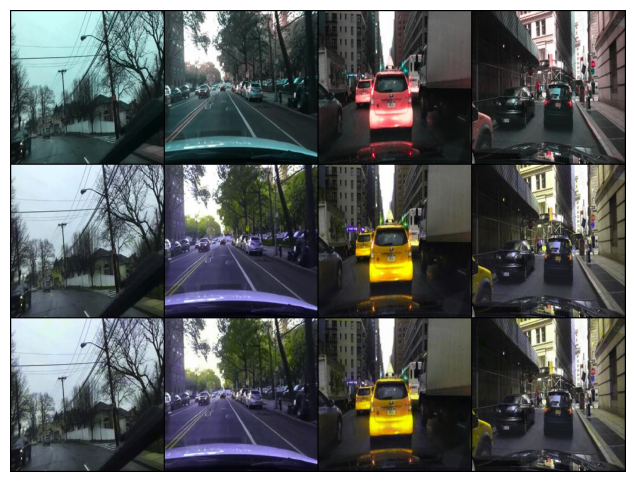

In [ ]:
# ---------------- Test Pix2Pix on Test Set ----------------
import os
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---------------- Paths ----------------
TEST_DIR = "/content/drive/MyDrive/pix2pix_dataset_t/test"  # فولدر بيانات الاختبار
CHECKPOINT_GEN = "/content/drive/MyDrive/pix2pix_result_t/gen_best_t.pth.tar"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
OUTPUT_TEST_DIR = "/content/drive/MyDrive/pix2pix_dataset_t/test_results"
os.makedirs(OUTPUT_TEST_DIR, exist_ok=True)

# ---------------- Dataset ----------------
class MapDatasetTest(torch.utils.data.Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))])
        self.transform = A.Compose([A.Resize(image_size,image_size)], additional_targets={"image0":"image"})
        self.to_tensor = A.Compose([A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)), ToTensorV2()])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        w = img.shape[1] // 2
        input_image = img[:, :w, :]
        target_image = img[:, w:, :]
        augmented = self.transform(image=input_image, image0=target_image)
        inp = self.to_tensor(image=augmented["image"])["image"]
        tar = self.to_tensor(image=augmented["image0"])["image"]
        return inp, tar, self.files[idx]

# ---------------- Generator ----------------
class U_NetBlock(torch.nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act="relu",use_dropout=False,use_instancenorm=True):
        super().__init__()
        norm = torch.nn.InstanceNorm2d if use_instancenorm else torch.nn.BatchNorm2d
        if down:
            layers=[torch.nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode="reflect"),
                    norm(out_channels),
                    torch.nn.LeakyReLU(0.2) if act=="leaky" else torch.nn.ReLU()]
        else:
            layers=[torch.nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
                    norm(out_channels),
                    torch.nn.ReLU() if act=="relu" else torch.nn.LeakyReLU(0.2)]
        self.conv = torch.nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = torch.nn.Dropout(0.5)
    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = torch.nn.Sequential(torch.nn.Conv2d(in_channels,features,4,2,1), torch.nn.LeakyReLU(0.2))
        self.down1 = U_NetBlock(features,features*2,down=True,act="leaky")
        self.down2 = U_NetBlock(features*2,features*4,down=True,act="leaky")
        self.down3 = U_NetBlock(features*4,features*8,down=True,act="leaky")
        self.down4 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.down5 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.down6 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.bottleneck = torch.nn.Sequential(torch.nn.Conv2d(features*8,features*8,4,2,1), torch.nn.ReLU())
        self.up1 = U_NetBlock(features*8,features*8,down=False,act="relu",use_dropout=True)
        self.up2 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        self.up3 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        self.up4 = U_NetBlock(features*8*2,features*8,down=False,act="relu")
        self.up5 = U_NetBlock(features*8*2,features*4,down=False,act="relu")
        self.up6 = U_NetBlock(features*4*2,features*2,down=False,act="relu")
        self.up7 = U_NetBlock(features*2*2,features,down=False,act="relu")
        self.final_up = torch.nn.Sequential(torch.nn.ConvTranspose2d(features*2,in_channels,4,2,1), torch.nn.Tanh())
    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

# ---------------- Load Model ----------------
gen = Generator().to(DEVICE)
checkpoint = torch.load(CHECKPOINT_GEN, map_location=DEVICE)
gen.load_state_dict(checkpoint["state_dict"])
gen.eval()
print("✅ Model loaded successfully!")

# ---------------- Load Test Data ----------------
test_dataset = MapDatasetTest(TEST_DIR)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ---------------- Run Test & Save Results ----------------
for i, (x, y, fname) in enumerate(test_loader):
    x, y = x.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
        y_fake = gen(x)
    # Save images
    for b in range(x.shape[0]):
        input_img = (x[b]*0.5+0.5).clamp(0,1)
        target_img = (y[b]*0.5+0.5).clamp(0,1)
        gen_img = (y_fake[b]*0.5+0.5).clamp(0,1)
        # حفظ كل صورة
        save_image(input_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_input.png"))
        save_image(target_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_target.png"))
        save_image(gen_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_gen.png"))
    if i==0:  # عرض أول batch
        grid = make_grid(torch.cat([x[:4], y[:4], y_fake[:4]], dim=0)*0.5+0.5, nrow=4)
        plt.figure(figsize=(12,6))
        plt.imshow(grid.permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.show()


✅ Model loaded successfully!


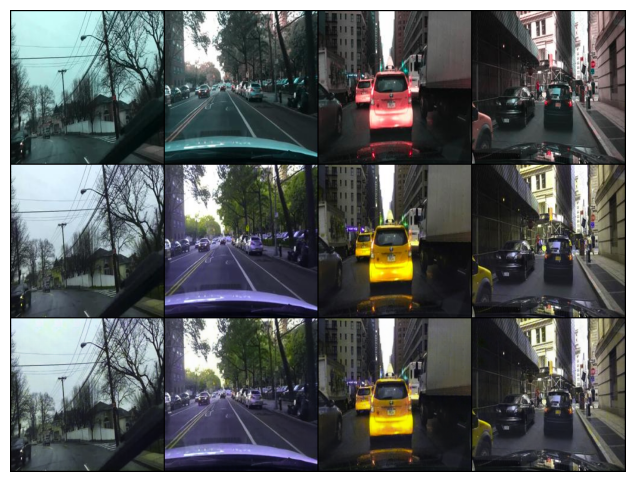

In [ ]:
# ---------------- Test Pix2Pix on Test Set ----------------
import os
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---------------- Paths ----------------
TEST_DIR = "/content/drive/MyDrive/pix2pix_dataset_t/test"  # فولدر بيانات الاختبار
CHECKPOINT_GEN = "/content/drive/MyDrive/pix2pix_result_t/gen_final_t.pth.tar"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
OUTPUT_TEST_DIR = "/content/drive/MyDrive/pix2pix_dataset_t/test_results"
os.makedirs(OUTPUT_TEST_DIR, exist_ok=True)

# ---------------- Dataset ----------------
class MapDatasetTest(torch.utils.data.Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))])
        self.transform = A.Compose([A.Resize(image_size,image_size)], additional_targets={"image0":"image"})
        self.to_tensor = A.Compose([A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)), ToTensorV2()])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        w = img.shape[1] // 2
        input_image = img[:, :w, :]
        target_image = img[:, w:, :]
        augmented = self.transform(image=input_image, image0=target_image)
        inp = self.to_tensor(image=augmented["image"])["image"]
        tar = self.to_tensor(image=augmented["image0"])["image"]
        return inp, tar, self.files[idx]

# ---------------- Generator ----------------
class U_NetBlock(torch.nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act="relu",use_dropout=False,use_instancenorm=True):
        super().__init__()
        norm = torch.nn.InstanceNorm2d if use_instancenorm else torch.nn.BatchNorm2d
        if down:
            layers=[torch.nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode="reflect"),
                    norm(out_channels),
                    torch.nn.LeakyReLU(0.2) if act=="leaky" else torch.nn.ReLU()]
        else:
            layers=[torch.nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
                    norm(out_channels),
                    torch.nn.ReLU() if act=="relu" else torch.nn.LeakyReLU(0.2)]
        self.conv = torch.nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = torch.nn.Dropout(0.5)
    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = torch.nn.Sequential(torch.nn.Conv2d(in_channels,features,4,2,1), torch.nn.LeakyReLU(0.2))
        self.down1 = U_NetBlock(features,features*2,down=True,act="leaky")
        self.down2 = U_NetBlock(features*2,features*4,down=True,act="leaky")
        self.down3 = U_NetBlock(features*4,features*8,down=True,act="leaky")
        self.down4 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.down5 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.down6 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.bottleneck = torch.nn.Sequential(torch.nn.Conv2d(features*8,features*8,4,2,1), torch.nn.ReLU())
        self.up1 = U_NetBlock(features*8,features*8,down=False,act="relu",use_dropout=True)
        self.up2 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        self.up3 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        self.up4 = U_NetBlock(features*8*2,features*8,down=False,act="relu")
        self.up5 = U_NetBlock(features*8*2,features*4,down=False,act="relu")
        self.up6 = U_NetBlock(features*4*2,features*2,down=False,act="relu")
        self.up7 = U_NetBlock(features*2*2,features,down=False,act="relu")
        self.final_up = torch.nn.Sequential(torch.nn.ConvTranspose2d(features*2,in_channels,4,2,1), torch.nn.Tanh())
    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

# ---------------- Load Model ----------------
gen = Generator().to(DEVICE)
checkpoint = torch.load(CHECKPOINT_GEN, map_location=DEVICE)
gen.load_state_dict(checkpoint["state_dict"])
gen.eval()
print("✅ Model loaded successfully!")

# ---------------- Load Test Data ----------------
test_dataset = MapDatasetTest(TEST_DIR)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ---------------- Run Test & Save Results ----------------
for i, (x, y, fname) in enumerate(test_loader):
    x, y = x.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
        y_fake = gen(x)
    # Save images
    for b in range(x.shape[0]):
        input_img = (x[b]*0.5+0.5).clamp(0,1)
        target_img = (y[b]*0.5+0.5).clamp(0,1)
        gen_img = (y_fake[b]*0.5+0.5).clamp(0,1)
        # حفظ كل صورة
        save_image(input_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_input.png"))
        save_image(target_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_target.png"))
        save_image(gen_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_gen.png"))
    if i==0:  # عرض أول batch
        grid = make_grid(torch.cat([x[:4], y[:4], y_fake[:4]], dim=0)*0.5+0.5, nrow=4)
        plt.figure(figsize=(12,6))
        plt.imshow(grid.permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.show()
